# Load functions

In [32]:
import pymatching
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from soft_info import get_repcode_IQ_map, llh_ratio

def process_string(input_str, verbose=False):
    # Step 1: Invert the order of the string
    reversed_str = input_str[::-1]
    if verbose:
        print("Reversed str:", reversed_str)

    # Step 2: Separate the last part of the string
    last_part = reversed_str.split(" ")[-1]
    if verbose:
        print("Count str:", last_part)
    
    # Step 3: Perform XOR operations on the last part
    xor_result = ''.join([str((int(last_part[i]) + int(last_part[i + 1])) % 2) for i in range(len(last_part) - 1)])
    if verbose:
        print("XOR result:", xor_result)
    
    # Step 4: Remove the remaining spaces in the first part of the string
    first_part = ''.join(reversed_str.split(" ")[:-1])
    if verbose:
        print("First part:", first_part)
    
    # Step 5: Separate each bit of the string into a list of a NumPy array
    numpy_list = np.array([int(bit) for bit in first_part]+ [int(bit) for bit in xor_result])
    if verbose:
        print("Numpy list:", numpy_list)
    
    return numpy_list


def reweight_edges_to_one(matching: pymatching.Matching):
    for edge in matching.edges():
        src_node, tgt_node, edge_data = edge
        fault_ids = edge_data.get('fault_ids', set())
        error_probability = edge_data.get('error_probability', -1.0)
        
        if tgt_node is None:
            matching.add_boundary_edge(src_node, weight=1, fault_ids=fault_ids, 
                              error_probability=error_probability, merge_strategy="replace")
        else:
            matching.add_edge(src_node, tgt_node, weight=1, fault_ids=fault_ids, 
                          error_probability=error_probability, merge_strategy="replace")


def soft_reweight_pymatching(matching : pymatching.Matching,  d : int, T : int, IQ_data, 
                             kde_dict: dict, layout : list, scaler_dict : dict,
                             p_data : float = None, p_meas : float = None, common_measure = None,
                             verbose : bool = False):

    p_data = p_data if p_data is not None else 6.836e-3  # Sherbrooke median
    p_meas = p_meas if p_meas is not None else 0

    if layout is not None:
        qubit_mapping = get_repcode_IQ_map(layout, T)

    for edge in matching.edges():
        src_node, tgt_node, edge_data = edge
        if verbose:
            print("\nEdge:", (src_node, tgt_node))
        fault_ids = edge_data.get('fault_ids', set())
        error_probability = edge_data.get('error_probability', -1.0)
        
        if tgt_node is None:  # always second pose None
            # Boundary edge (logical on it)
            new_weight = -np.log(p_data / (1 - p_data))

            if common_measure is not None:
                new_weight = round(new_weight / common_measure) * common_measure
                
            matching.add_boundary_edge(src_node, weight=new_weight, fault_ids=fault_ids, 
                              error_probability=error_probability, merge_strategy="replace")
            if verbose:
                print("Boundary edge weight: ", new_weight)

            _has_time_component = False
            continue
        elif tgt_node == src_node + 1:  # always first pos the smaller
            # Data edge
            new_weight = -np.log(p_data / (1 - p_data))
            if common_measure is not None:
                new_weight = round(new_weight / common_measure) * common_measure
            if verbose:
                print("Data edge weight: ", new_weight)
        elif tgt_node == src_node + (d-1):
            # Time edge
            #TODO implement adding a new edge for hard meas flip
            new_weight = 0 #-np.log(p_meas / (1 - p_meas))
            _has_time_component = True
            if verbose:
                print("Time edge weight: ", new_weight)
        elif tgt_node == src_node + (d-1) + 1:
            # mixed edge
            # TODO implement adding a new DIAG edge for hard meas flip
            new_weight = -np.log(p_data / (1 - p_data))# - np.log(p_meas / (1 - p_meas))
            _has_time_component = True
            if verbose:
                print("Mixed edge weight: ", new_weight)

        if _has_time_component: 
            #Structure of IQ data = [link_0, link_1, link_3, link_0, link_1, .., code_qubit_1, ...]
            # equivalent to       = [node_0, node_1, node_3, node_4, node_5, .. ]
            # =>
            IQ_point = IQ_data[src_node]
            layout_qubit_idx = qubit_mapping[src_node]
            kde_0, kde_1 = kde_dict.get(layout_qubit_idx, (None, None))
            scaler = scaler_dict.get(layout_qubit_idx, None)
            llh_weight = llh_ratio(IQ_point, kde_0, kde_1, scaler)
            
            if verbose:
                print("LLH weight: ", llh_weight)
        
            new_weight += llh_weight

            # Round the weights to common measure
            if common_measure is not None:
                new_weight = round(new_weight / common_measure) * common_measure

        # Update the edge weight
        matching.add_edge(src_node, tgt_node, weight=new_weight, fault_ids=fault_ids, 
                          error_probability=error_probability, merge_strategy="replace")



def draw_matching_graph(matching, d, T):
    G = nx.Graph()
    pos = {}
    edge_colors = []
    
    for edge in matching.edges():
        src_node, tgt_node, edge_data = edge
        if tgt_node is not None:
            G.add_edge(src_node, tgt_node, weight=edge_data['weight'])
            if edge_data.get('fault_ids'):
                edge_colors.append('r')
            else:
                edge_colors.append('k')
        
        x_src = src_node % (d-1)
        y_src = src_node // (d-1)
        pos[src_node] = (x_src, -y_src)
    
    nx.draw(G, pos, with_labels=True, node_color='white', edge_color=edge_colors, font_weight='bold', node_size=700, font_size=18)
    
    edge_weights = nx.get_edge_attributes(G, 'weight')
    labels = {k: f"{v:.2f}" for k, v in edge_weights.items()}
    
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

    for edge in matching.edges():
        src_node, tgt_node, edge_data = edge
        if tgt_node is None:
            x_src = src_node % (d-1)
            y_src = src_node // (d-1)
            color = 'r' if edge_data.get('fault_ids') == set() else 'k'
            weight_text = f"{edge_data.get('weight'):.2f}"
            if x_src == 0:
                plt.plot([x_src, x_src - 0.5], [-y_src, -y_src], color=color)
                plt.text(x_src - 0.3, -y_src + 0.05, weight_text)
            elif x_src == d - 2:
                plt.plot([x_src, x_src + 0.5], [-y_src, -y_src], color=color)
                plt.text(x_src + 0.2, -y_src + 0.05, weight_text)

    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=700)
    
    plt.show()      


# Load data

In [7]:
import numpy as np
import stim
import pymatching

# Code parameters
d=3
T=3
layout = [25, 19, 26, 22, 16] # Hardcoded for testing purposes, can be retrieved


circuit = stim.Circuit.generated("repetition_code:memory",
                                 distance=d,
                                 rounds=T,
                                 after_clifford_depolarization=0.1)

model = circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

#draw_matching_graph(matching, d, T)

In [9]:
from result_saver import SaverProvider
from soft_info import get_counts, get_KDEs
provider = SaverProvider()


job = provider.retrieve_job("cmyhbrqrmwhg008bs4h0")
memory = job.result().get_memory()

kde_dict, scaler_dict = get_KDEs(provider, 'ibmq_mumbai', layout, bandwidths=0.2, plot=False)


In [13]:
print("Memory:", memory.shape)

Memory: (1000, 9)


In [81]:
from tqdm import tqdm

VERBOSE = False

actual_observables = np.array([[False]]) # hardcoded, can be retrieved
num_errors = 0

i = 0
w_idx_lst = []
for shot in tqdm(range(len(memory))[:]):
    i += 1
    IQ_data = memory[shot]

    counts = get_counts([IQ_data], kde_dict, scaler_dict, layout, T, verbose=False)
    count_key = next(iter(counts.keys()))

    if count_key == '000 00 00 00':
        #print("Skipping all zeros")
        continue    

    soft_reweight_pymatching(matching, d, T, IQ_data, kde_dict, layout, scaler_dict, common_measure=0.0001, verbose=False)  

    array_processed_string = process_string(count_key, verbose=False)

    predicted_observables = matching.decode(array_processed_string)



    if predicted_observables == [0]:
        continue
    
    #print(f"Wrong decoding at index {i}")
    w_idx_lst.append(i)

    
    if VERBOSE:
        print("Count key:", count_key)
        print("process_string:", array_processed_string)

    if VERBOSE:
        draw_matching_graph(matching, d, T)

    if VERBOSE:
        matched_edges = matching.decode_to_edges_array(array_processed_string)
        print("matched_edges: ", matched_edges)
        print("Estimated flip:", predicted_observables)

    num_errors += not np.array_equal(actual_observables[0, :], predicted_observables) # 0 can be changed to i if multiple observables and multiple syndromes per ovbservable

print("Num errors:", num_errors)

100%|██████████| 1000/1000 [01:10<00:00, 14.23it/s]

Num errors: 35


 70%|███████   | 14/20 [00:00<00:00, 18.13it/s]

Count key: 001 01 10 00
process_string: [0 0 0 1 1 0 1 0]


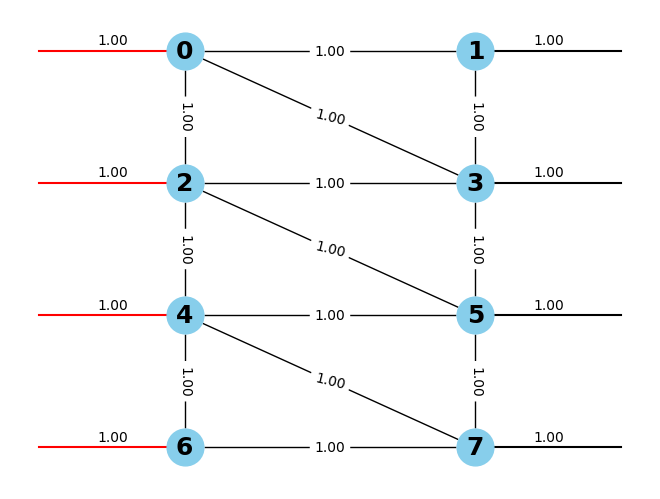

 90%|█████████ | 18/20 [00:01<00:00, 15.18it/s]

matched_edges:  [[ 3 -1]
 [ 4  6]]
Estimated flip: [1]


100%|██████████| 20/20 [00:01<00:00, 16.03it/s]

Num errors: 1


In [72]:
from tqdm import tqdm

VERBOSE = True

actual_observables = np.array([[False]]) # hardcoded, can be retrieved
num_errors = 0

i = 0
nw_idx_lst = []
for shot in tqdm(range(len(memory))[510:530]):
    i += 1
    IQ_data = memory[shot]

    counts = get_counts([IQ_data], kde_dict, scaler_dict, layout, T, verbose=False)
    count_key = next(iter(counts.keys()))

    if count_key == '000 00 00 00':
        #print("Skipping all zeros")
        continue    

    reweight_edges_to_one(matching)  

    array_processed_string = process_string(count_key, verbose=False)

    predicted_observables = matching.decode(array_processed_string)

    if predicted_observables == [0]:
        continue
    
    #print(f"Wrong decoding at index {i}")
    nw_idx_lst.append(i)
    
    if VERBOSE:
        print("Count key:", count_key)
        print("process_string:", array_processed_string)

    if VERBOSE:
        draw_matching_graph(matching, d, T)

    if VERBOSE:
        matched_edges = matching.decode_to_edges_array(array_processed_string)
        print("matched_edges: ", matched_edges)
        print("Estimated flip:", predicted_observables)

    num_errors += not np.array_equal(actual_observables[0, :], predicted_observables) # 0 can be changed to i if multiple observables and multiple syndromes per ovbservable

print("Num errors:", num_errors)

In [62]:
# find the indices that are just in one list
w_idx_lst = set(w_idx_lst)
nw_idx_lst = set(nw_idx_lst)
unique_idx_list = list(w_idx_lst.symmetric_difference(nw_idx_lst))

print("Different wrong indices:", unique_idx_list)
print("w_idx_lst:", w_idx_lst)
print("nw_idx_lst:", nw_idx_lst)

Different wrong indices: [525]
w_idx_lst: {388, 262, 136, 392, 780, 911, 656, 401, 657, 660, 917, 536, 409, 413, 802, 547, 420, 808, 431, 563, 949, 313, 831, 962, 579, 453, 456, 712, 973, 469, 488, 240, 756, 506, 895}
nw_idx_lst: {388, 262, 136, 392, 780, 525, 911, 656, 401, 657, 660, 917, 536, 409, 413, 802, 547, 420, 808, 431, 563, 949, 313, 831, 962, 579, 453, 456, 712, 973, 469, 488, 240, 756, 506, 895}
